# Time Series - `ARCH` model

## What does `statsmodels` include?

"statsmodels" is a comprehensive Python package for statistical modeling and econometrics, offering features such as:

+ Linear regression, generalized linear models (GLM), and Bayesian regression

+ Time series models: `AR`, `MA`, `ARMA`, `ARIMA`, `SARIMA`, `SARIMAX`, `VAR`, `ARCH`, `GARCH`

+ Descriptive statistics and statistical hypothesis testing

+ Tools for autocorrelation analysis: `ACF`, `PACF`, and stationarity tests like the `Dickey-Fuller test`

# What is the `ARCH` model?

## Definition:

An `ARCH` **(Autoregressive Conditional Heteroskedasticity)** model is a statistical model used to capture time-varying volatility (changing variance) in time series data - especially financial returns.

Unlike constant-variance models, ARCH allows the variance of the error term to change over time based on past squared residuals.

ARCH is particularly useful when modeling volatility clustering, where high-volatility periods tend to follow other high-volatility periods.
## Components:

+ **Mean equation**: Describes the actual values of the time series (e.g., stock returns), typically modeled with `ARMA` or constant mean.

+ **Conditional variance equation**: The variance of current errors depends on past squared errors, i.e.,

$$\sigma_t^2 = \alpha_0 + \alpha_1 \cdot \varepsilon_{t-1}^2 + \cdots + \alpha_q \cdot \varepsilon_{t-q}^2$$


+ **Order** `(q)`: Number of lagged squared residuals (shocks) used in the conditional variance equation.

# `Index2018` data project
## Dataset description:
This project is based on a dataset sourced from Kaggle that provides historical daily closing values of major global stock market indices. The data is used as a foundation for applying time series analysis techniques, including VAR (Vector Autoregression) and ARCH/GARCH models.

The dataset spans multiple years and contains synchronized data from five major stock indices, enabling both univariate and multivariate time series modeling.

Each row represents one trading day, and the dataset includes the following columns:

+ `date` (string, format: DD/MM/YYYY):

+ The calendar date of the recorded index values.

+ 🇺🇸 `spx` (float):

+ Daily closing value of the S&P 500 index (USA).

+ 🇩🇪 `dax` (float):

+ Daily closing value of the DAX index (Germany).

+ 🇬🇧 `ftse` (float):

+ Daily closing value of the FTSE 100 index (United Kingdom).

+ 🇯🇵 `nikkei` (float):

+ Daily closing value of the Nikkei 225 index (Japan).

## Import the libraries:

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the Data:

In [30]:
raw_csv_data = pd.read_csv("Index2018/Index2018.csv")
raw_csv_data.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


## Preprocessing:

### Format to datatype:

In [31]:
raw_csv_data['date'] = pd.to_datetime(raw_csv_data['date'], format = '%d/%m/%Y')
raw_csv_data.head()

,date,spx,dax,ftse,nikkei
0,1994-01-07,469.90,2224.95,3445.98,18124.01
1,1994-01-10,475.27,2225.00,3440.58,18443.44
2,1994-01-11,474.13,2228.10,3413.77,18485.25
3,1994-01-12,474.17,2182.06,3372.02,18793.88
4,1994-01-13,472.47,2142.37,3360.01,18577.26


### The `date` as index:

In [32]:
raw_csv_date = raw_csv_data.set_index('date', inplace=True)
raw_csv_data.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [33]:
raw_csv_data.count()

spx       6269
dax       6269
ftse      6269
nikkei    6269
dtype: int64

### The `.reindex()` operation:
Extend the index to include all business days within the date range, inserting NaNs where data was missing (e.g., holidays, weekends).

+ `.asfreq('B')` - changes the frequency, but does not add missing dates if they weren’t already in the index.

+ `.reindex()` - adds missing dates and gives you full control over the index.

In [34]:
full_range = pd.date_range(start=raw_csv_data.index.min(), end=raw_csv_data.index.max(), freq='D')
df_comp = raw_csv_data.reindex(full_range)
df_comp.head()

,spx,dax,ftse,nikkei
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-08,NaN,NaN,NaN,NaN
1994-01-09,NaN,NaN,NaN,NaN
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25


In [35]:
df_comp.count()

spx       6269
dax       6269
ftse      6269
nikkei    6269
dtype: int64

### Replace missing values:
`.ffill()` fills missing values by propagating the last valid (non-missing) value forward along the specified axis.

In [36]:
df_comp = df_comp.ffill()
df_comp.head()

,spx,dax,ftse,nikkei
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-08,469.90,2224.95,3445.98,18124.01
1994-01-09,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25


In [37]:
df_comp.count()

spx       8789
dax       8789
ftse      8789
nikkei    8789
dtype: int64

## Train data & Test data split

In [38]:
df_comp['market_value']=df_comp['ftse']

del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']

size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

import warnings
warnings.filterwarnings("ignore")

In [39]:
size

7031

In [40]:
df.head()

,market_value
1994-01-07,3445.98
1994-01-08,3445.98
1994-01-09,3445.98
1994-01-10,3440.58
1994-01-11,3413.77


## The LLR Test
### What is the LLR Test?
LLR (Likelihood Ratio Test) is a statistical test that compares two nested models (i.e., one is a simplified version of the other). For example:

+ ARCH(1) is a simplified case of ARCH(2)

+ GARCH(1,1) is a simplified case of GARCH(2,1)

LLR answers the question:
Does the more complex model fit the data significantly better than the simpler one?
### How does it work?
For two models:

+ `logL1` = log-likelihood of the simpler model

+ `logL2` = log-likelihood of the more complex model

+ `df` = number of additional parameters in the complex model

### Test statistic:

$$LLR = 2 \cdot (\log L_2 - \log L_1)$$

### What does the result mean?
If $p-value < 0.05$, the complex model is statistically better

If $p-value > 0.05$, the simpler model is sufficient (i.e., no need to complicate things)

In [41]:
from scipy.stats.distributions import chi2

def LLR_test(fitted_mod1, fitted_mod2, DF=1):
    L1 = fitted_mod1.llf
    L2 = fitted_mod2.llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns & Squared Returns

### `returns` – percentage changes

$ \frac{P_t - P_{t-1}}{P_{t-1}} = \text{percentage change} $

These are **daily percentage changes** in the value of the index.

**Why do we need this?**

+ ARCH/GARCH models do **not** model price levels – they model the **volatility of returns**.
+ Returns often have a **mean close to zero**, but their **variance can change over time** – and that’s the key point.



### `squared returns` – squared percentage changes

This is essentially a **local variance estimate**, because:

$ \text{Var}(X) = E[(X - \mu)^2] $ and if $ \mu \approx 0 $, then: $ \text{Var}(X) \approx E[X^2] $

**Why?**

+ ARCH and GARCH models estimate **volatility**, i.e., the behavior of $ \text{Var}(X_t) $
+ Volatility is **not constant** over time – we often observe **volatility clustering** (after a storm comes... another storm)



### How does it look visually?

+ `returns`: jump up and down, with an average around 0
+ `squared returns`: show clear **clusters of large values** (high volatility periods)

This is why **ARCH/GARCH models learn from `squared returns`** – to predict future changes in volatility, not returns themselves.


In [42]:
df['returns'] = df['market_value'].pct_change(1)*100

In [43]:
df['sq_returns'] = df['returns'] * df['returns']

## Returns vs Squared Returns

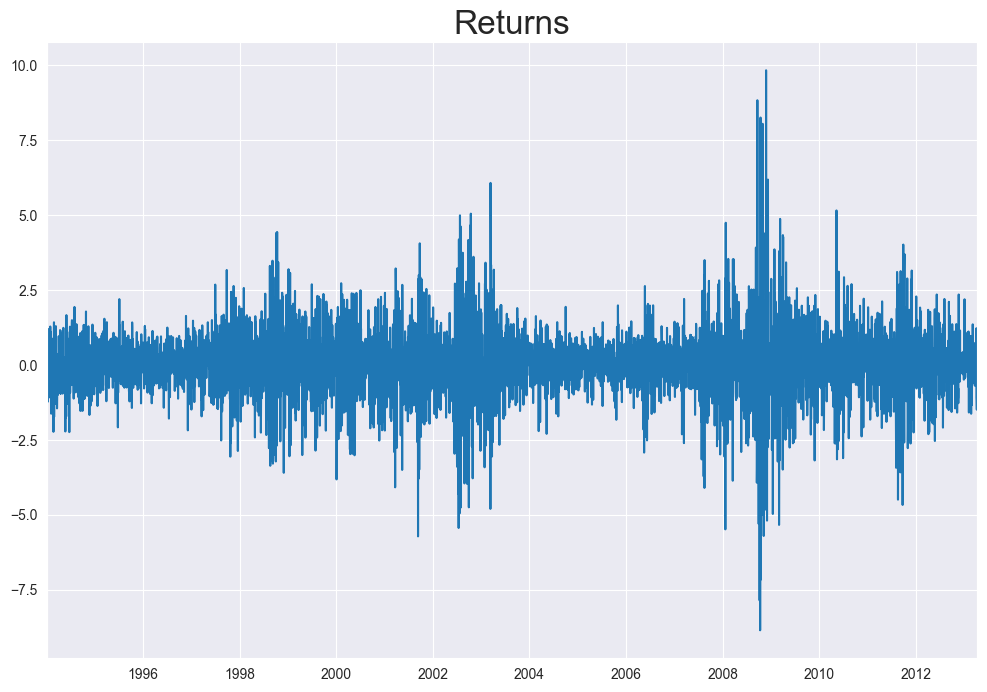

In [44]:
df['returns'].plot(figsize=(12,8))
plt.title("Returns", size = 24)
plt.show()

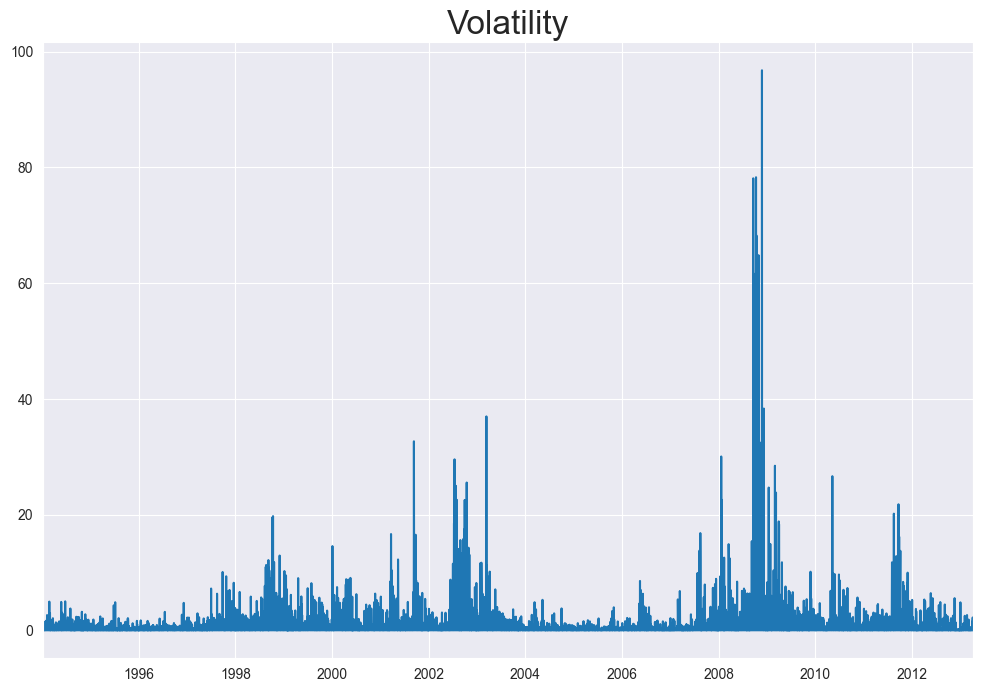

In [45]:
df['sq_returns'].plot(figsize=((12,8)))
plt.title("Volatility", size = 24)
plt.show()

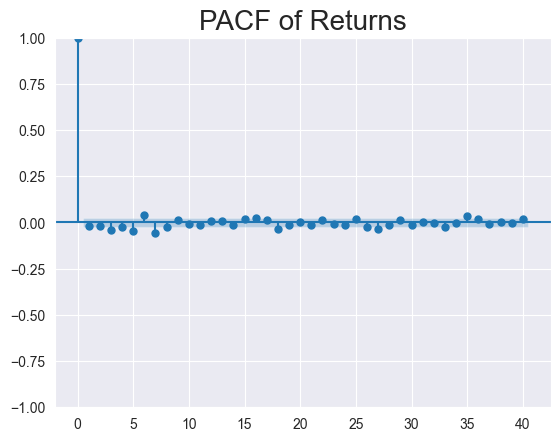

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(df.returns[1:], lags = 40)
plt.title("PACF of Returns", size = 20)
plt.show()

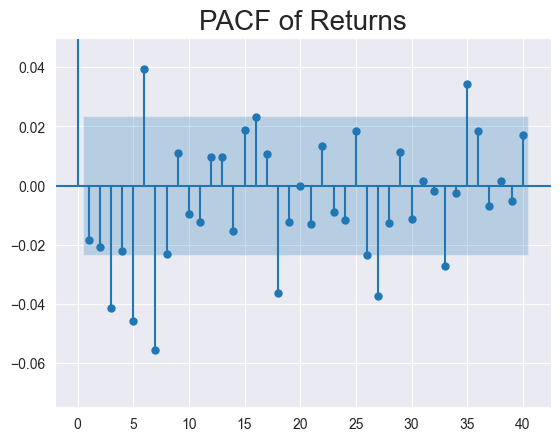

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(df.returns[1:], lags = 40)
plt.title("PACF of Returns", size = 20)
plt.ylim(-0.075, 0.05)  # narrowing Y axis
plt.show()


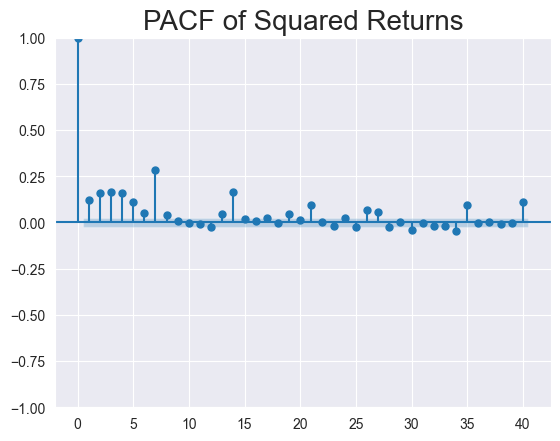

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(df.sq_returns[1:], lags = 40)
plt.title("PACF of Squared Returns", size = 20)
plt.show()

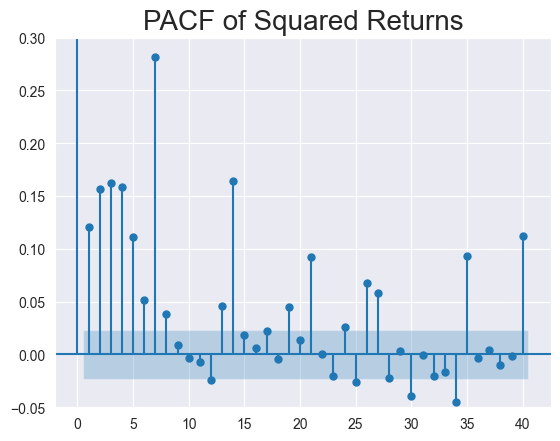

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(df.sq_returns[1:], lags = 40)
plt.title("PACF of Squared Returns", size = 20)
plt.ylim(-0.05, 0.3)  # narrowing Y axis
plt.show()

## `ARCH()` model

In [50]:
from arch import arch_model

In [51]:
model_arch_1 = arch_model(df.returns[1:])
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     34,   Neg. LLF: 8654.501694554965
Iteration:     10,   Func. Count:     64,   Neg. LLF: 8621.88452063908
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8617.152713345502
            Iterations: 14
            Function evaluations: 85
            Gradient evaluations: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8617.15
Distribution:                  Normal   AIC:                           17242.3
Method:            Maximum Likelihood   BIC:                           17269.7
                                        No. Observations:                 7030
Date:                Thu, Jul 03 2025   Df Residuals:                     7029
Time:                        15:17:05   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0333  8.718e-03      3.822  1.324e-04 [1.623e-02,5.040e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.6048e-03  1.284e-03      3.587  3.351e-04 [2.088e-03,7.121e-03]
alpha[1]       0.0501  6.072e-03      8.259  1.469e-16 [3.825e-02,6.205e-02]
beta[1]        0.9454  6.412e-03    147.429      0.000     [  0.933,  0.958]
============================================================================

Covariance estimator: robust
"""

## The Simple `ARCH(1)`

In [52]:
model_arch_1 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 1)
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     30,   Neg. LLF: 9712.78784032783
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9712.78784032783
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9712.79
Distribution:                  Normal   AIC:                           19431.6
Method:            Maximum Likelihood   BIC:                           19452.1
                                        No. Observations:                 7030
Date:                Thu, Jul 03 2025   Df Residuals:                     7029
Time:                        15:17:06   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0213  1.160e-02      1.836  6.632e-02 [-1.435e-03,4.404e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7872  4.317e-02     18.236  2.686e-74 [  0.703,  0.872]
alpha[1]       0.2205  3.773e-02      5.845  5.057e-09 [  0.147,  0.294]
========================================================================

Covariance estimator: robust
"""

In [53]:
model_arch_1 = arch_model(df.returns[1:], mean = "AR", lags = [2, 3, 6], vol = "ARCH", p = 1, dist = "ged")
results_arch_1 = model_arch_1.fit(update_freq = 5)
results_arch_1.summary()

Iteration:      5,   Func. Count:     55,   Neg. LLF: 7452133.366671326
Iteration:     10,   Func. Count:    102,   Neg. LLF: 8109.794600399044
Iteration:     15,   Func. Count:    150,   Neg. LLF: 8001.4438086102255
Iteration:     20,   Func. Count:    198,   Neg. LLF: 7914.395682037524
Iteration:     25,   Func. Count:    244,   Neg. LLF: 7909.471007932619
Iteration:     30,   Func. Count:    291,   Neg. LLF: 7908.887967352444
Iteration:     35,   Func. Count:    338,   Neg. LLF: 7908.8694910111935
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7908.8652358619875
            Iterations: 38
            Function evaluations: 365
            Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                            returns   R-squared:                      -0.000
Mean Model:                                    AR   Adj. R-squared:                 -0.001
Vol Model:                                   ARCH   Log-Likelihood:               -7908.87
Distribution:      Generalized Error Distribution   AIC:                           15831.7
Method:                        Maximum Likelihood   BIC:                           15879.7
                                                    No. Observations:                 7024
Date:                            Thu, Jul 03 2025   Df Residuals:                     7020
Time:                                    15:17:06   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -1.9845e-08  4.986e-07 -3.980e-02      0.968 [-9.970e-07,9.574e-07]
returns[2] -6.3809e-09  6.166e-07 -1.035e-02      0.992 [-1.215e-06,1.202e-06]
returns[3] -7.6599e-08  6.335e-07     -0.121      0.904 [-1.318e-06,1.165e-06]
returns[6]  9.1616e-08  1.112e-06  8.239e-02      0.934 [-2.088e-06,2.271e-06]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.4899  2.293e-02     21.366 2.767e-101 [  0.445,  0.535]
alpha[1]       0.2761  3.393e-02      8.138  4.011e-16 [  0.210,  0.343]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0100  3.252e-02     31.056 9.445e-212 [  0.946,  1.074]
========================================================================

Covariance estimator: robust
"""

## Higher-Lag `ARCH()` Models

In [54]:
model_arch_2 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 2)
results_arch_2 = model_arch_2.fit(update_freq = 5)
results_arch_2.summary()

Iteration:      5,   Func. Count:     36,   Neg. LLF: 9757.4819466005
Iteration:     10,   Func. Count:     63,   Neg. LLF: 9657.729978671774
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9657.729978671723
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9657.73
Distribution:                  Normal   AIC:                           19323.5
Method:            Maximum Likelihood   BIC:                           19350.9
                                        No. Observations:                 7030
Date:                Thu, Jul 03 2025   Df Residuals:                     7029
Time:                        15:17:07   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0245  1.149e-02      2.129  3.324e-02 [1.944e-03,4.700e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.7609  4.158e-02     18.299  8.453e-75     [  0.679,  0.842]
alpha[1]       0.1567  3.006e-02      5.213  1.856e-07   [9.780e-02,  0.216]
alpha[2]       0.0606  1.869e-02      3.241  1.192e-03 [2.393e-02,9.718e-02]
============================================================================

Covariance estimator: robust
"""

In [55]:
model_arch_3 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 3)
results_arch_3 = model_arch_3.fit(update_freq = 5)
results_arch_3.summary()

Iteration:      5,   Func. Count:     40,   Neg. LLF: 9791.145902457156
Iteration:     10,   Func. Count:     73,   Neg. LLF: 9420.243307557066
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9418.905248282605
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9418.91
Distribution:                  Normal   AIC:                           18847.8
Method:            Maximum Likelihood   BIC:                           18882.1
                                        No. Observations:                 7030
Date:                Thu, Jul 03 2025   Df Residuals:                     7029
Time:                        15:17:07   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0258  1.115e-02      2.314  2.069e-02 [3.944e-03,4.767e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.5884  2.858e-02     20.590  3.357e-94     [  0.532,  0.644]
alpha[1]       0.1921  3.396e-02      5.656  1.548e-08     [  0.126,  0.259]
alpha[2]       0.0519  1.503e-02      3.452  5.559e-04 [2.242e-02,8.132e-02]
alpha[3]       0.1641  3.112e-02      5.272  1.346e-07     [  0.103,  0.225]
============================================================================

Covariance estimator: robust
"""

In [56]:
model_arch_13 = arch_model(df.returns[1:], mean = "Constant", vol = "ARCH", p = 13)
results_arch_13 = model_arch_13.fit(update_freq = 5)
results_arch_13.summary()

Iteration:      5,   Func. Count:     89,   Neg. LLF: 12410.78743964501
Iteration:     10,   Func. Count:    176,   Neg. LLF: 8529.875812427981
Iteration:     15,   Func. Count:    261,   Neg. LLF: 8516.495305014141
Iteration:     20,   Func. Count:    345,   Neg. LLF: 8394.196603688342
Iteration:     25,   Func. Count:    425,   Neg. LLF: 9112.315502294172
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8393.49122744935
            Iterations: 28
            Function evaluations: 470
            Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8393.49
Distribution:                  Normal   AIC:                           16817.0
Method:            Maximum Likelihood   BIC:                           16919.9
                                        No. Observations:                 7030
Date:                Thu, Jul 03 2025   Df Residuals:                     7029
Time:                        15:17:08   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0228  8.250e-03      2.767  5.658e-03 [6.658e-03,3.900e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1603  2.869e-02      5.586  2.327e-08      [  0.104,  0.216]
alpha[1]       0.0725  2.228e-02      3.254  1.138e-03    [2.884e-02,  0.116]
alpha[2]   6.3849e-12  1.353e-02  4.718e-10      1.000 [-2.653e-02,2.653e-02]
alpha[3]       0.0185  1.666e-02      1.108      0.268 [-1.419e-02,5.110e-02]
alpha[4]       0.0216  1.719e-02      1.254      0.210 [-1.213e-02,5.527e-02]
alpha[5]   6.0917e-11  2.537e-02  2.401e-09      1.000 [-4.972e-02,4.972e-02]
alpha[6]       0.1404  2.693e-02      5.214  1.843e-07    [8.765e-02,  0.193]
alpha[7]       0.5673  8.066e-02      7.033  2.017e-12      [  0.409,  0.725]
alpha[8]       0.1042  2.082e-02      5.004  5.605e-07    [6.337e-02,  0.145]
alpha[9]   1.0314e-10  2.235e-02  4.615e-09      1.000 [-4.380e-02,4.380e-02]
alpha[10]  1.1301e-11  1.474e-02  7.665e-10      1.000 [-2.890e-02,2.890e-02]
alpha[11]  3.4825e-03  1.646e-02      0.212      0.832 [-2.878e-02,3.575e-02]
alpha[12]  4.5732e-11  1.481e-02  3.087e-09      1.000 [-2.904e-02,2.904e-02]
alpha[13]      0.0721  3.457e-02      2.084  3.713e-02    [4.299e-03,  0.140]
=============================================================================

Covariance estimator: robust
"""